### <span style='color:blue '> Modélisation </span>

### Les Librairies:

In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy import stats
import joblib

### Récupération des données

In [89]:
data_clean =pd.read_csv("data_cleaned.csv")

In [90]:
data_clean.shape

(1559, 14)

In [91]:
data_clean.head()

,OSEBuildingID,BuildingType,PrimaryPropertyType,NumberofBuildings,NumberofFloors,PropertyGFABuilding(s),LargestPropertyUseType,ENERGYSTARScore,SiteEnergyUse(kBtu),TotalGHGEmissions,Latitude,Longitude,BuildingAge,PropertyGFAParkingbool
0,400,NonResidential,Office,1.0,6.0,72450.0,Office,45.0,15.691288,3.876189,47.606799,-122.337100,115,1.0
1,442,NonResidential,Office,1.0,4.0,155934.0,Office,59.0,16.634519,4.769328,47.621476,-122.343050,74,1.0
2,499,NonResidential,Office,1.0,3.0,55188.0,Office,76.0,15.314463,4.910373,47.570897,-122.297412,13,1.0
3,559,NonResidential,Office,1.0,4.0,186971.0,Office,86.0,16.354152,5.428995,47.621243,-122.329786,40,0.0
4,714,NonResidential,Office,1.0,5.0,160800.0,Office,95.0,15.713124,5.568115,47.603730,-122.337367,110,1.0



#### <span style='color:blue '> 1.Prétraitement </span>

'OSEBuildingID' ne nous sera pas utile, nous la supprimerons du jeu de données.

In [92]:
data_clean=data_clean.drop(['OSEBuildingID'], axis=1)

#### <span style='color:green'>1.1.sauvegarde séparée du energy star score</span>

- 'ENERGYSTARScore': Nous allons l'écarter du dataset pour vérifier si cette variable a un impact sur la qualité de prédiction.

In [93]:
energy_star_score = data_clean['ENERGYSTARScore']
data_clean.drop('ENERGYSTARScore', axis=1, inplace=True)

#### <span style='color:green'>1.2.Séparation des variables explicatives (features) et des étiquettes (targets) </span>
Nous cherchons à élaborer un modèle de prédiction des émissions de CO2 et de la consommation totale d'énergie à partir d'un jeu de données.


#### Les variables cibles :

- 'TotalGHGEmissions': The total amount of greenhouse gas emissions, including carbon dioxide, methane, and nitrous oxide gases released into the atmosphere as a result of energy consumption at the property, measured in metric tons of carbon dioxide equivalent.
- 'SiteEnergyUse(kBtu)': The annual amount of energy consumed by the property from all sources of energy.

#### Préparation des jeux d'entrainement et de test

In [94]:
# Features : toutes les colonnes, sauf les cibles et "ENERGYSTARScore" pour évaluation finale
X = data_clean.drop(['SiteEnergyUse(kBtu)','TotalGHGEmissions'], axis=1)

y = data_clean[['SiteEnergyUse(kBtu)','TotalGHGEmissions']]

In [95]:
X.shape

(1559, 10)

In [96]:
y.shape

(1559, 2)

#### <span style='color:green'>1.2. Préparation des données numériques et catégoriques</span>

Les variables numériques doivent être standardisées et les variables catégoriques doivent être transformées en numérique

D’abord nous les séparons: 

#### <span style='color:orange'> 1.2.1. Les variables numériques </span>

In [97]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [98]:
numeric_columns = X.select_dtypes(include = ['int64','float64']).columns

In [99]:
numeric_columns

Index(['NumberofBuildings', 'NumberofFloors', 'PropertyGFABuilding(s)',
       'Latitude', 'Longitude', 'BuildingAge', 'PropertyGFAParkingbool'],
      dtype='object')

#### <span style='color:darkviolet'>Standardisation des variables numériques </span>

In [100]:
list_to_scale = numeric_columns.drop(['PropertyGFAParkingbool'])

In [101]:
ss = StandardScaler()
X[list_to_scale] = ss.fit_transform(X[list_to_scale])

In [13]:
scaled_features = X.copy()

In [14]:
scaler = StandardScaler()
X[numeric_columns] = scaler.fit_transform(X[numeric_columns])

#### <span style='color:orange'> 1.2.3. Les variables catégoriques </span>

In [102]:
category_columns = X.select_dtypes(include = ['object']).columns

In [103]:
category_columns

Index(['BuildingType', 'PrimaryPropertyType', 'LargestPropertyUseType'], dtype='object')

Parmi ces variables, nous allons conservé uniquement "LargestPropertyUseType"

In [104]:
X=X.drop(['BuildingType','LargestPropertyUseType'], axis= 1)

In [105]:
category_columns = X.select_dtypes(include = ['object']).columns

#### <span style='color:darkviolet'> One-hot-encoding (transformation des variables catégoriques aux numériques)</span>

In [106]:
encoder = OneHotEncoder(sparse=False)

df= pd.DataFrame(data=encoder.fit_transform(X[category_columns]), 
                       columns=encoder.get_feature_names())

In [107]:
df.columns

Index(['x0_Education', 'x0_Food Sales & Service', 'x0_Healthcare',
       'x0_Lodging/Residential', 'x0_Mixed Use', 'x0_Office', 'x0_Other',
       'x0_Public Assembly', 'x0_Retail', 'x0_Technology/Science',
       'x0_Warehouse', 'x0_Warehouse/Storage'],
      dtype='object')

In [108]:
X.columns

Index(['PrimaryPropertyType', 'NumberofBuildings', 'NumberofFloors',
       'PropertyGFABuilding(s)', 'Latitude', 'Longitude', 'BuildingAge',
       'PropertyGFAParkingbool'],
      dtype='object')

Maintenant que les variables numériques et catégoriques sont prêtes, nous allons les mettre ensemble

#### <span style='color:orange'> 1.2.4. Fusionner les variables numériques et catégoriques </span>

In [109]:
X = pd.concat([X[numeric_columns], df], axis=1)

In [110]:
X.shape

(1559, 19)

In [111]:
X.head(10)

,NumberofBuildings,NumberofFloors,PropertyGFABuilding(s),Latitude,Longitude,BuildingAge,PropertyGFAParkingbool,x0_Education,x0_Food Sales & Service,x0_Healthcare,x0_Lodging/Residential,x0_Mixed Use,x0_Office,x0_Other,x0_Public Assembly,x0_Retail,x0_Technology/Science,x0_Warehouse,x0_Warehouse/Storage
0,-0.065008,0.654731,0.000832,-0.183604,-0.165021,1.670410,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.065008,0.146021,1.061302,0.115295,-0.406098,0.419872,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.065008,-0.108333,-0.218442,-0.914771,1.443005,-1.440685,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.065008,0.146021,1.455555,0.110550,0.131299,-0.617160,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.065008,0.400376,1.123113,-0.246102,-0.175839,1.517905,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5,-0.065008,-0.108333,-0.056089,-0.089469,0.473622,0.999390,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,-0.065008,-0.108333,-0.645099,0.035118,0.009921,0.968889,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
7,-0.065008,-0.362688,-0.556587,0.051148,-0.015642,0.724881,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
8,-0.065008,-0.617043,-0.618474,2.237672,-0.414845,-1.227178,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9,-0.065008,0.909086,-0.348771,-0.130521,-0.255782,1.731412,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


 
#### <span style='color:blue '> 2. Modèle Baseline: DummyRegressor  </span>

Nous allons créer un modèle baseline pour évaluer les performances de nos futurs modèles et vérifier qu’ils améliorent les prédictions. Pour cette baseline, nous utiliserons une DummyRegressor.

In [112]:
import timeit

start_time = timeit.default_timer()

In [113]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y['SiteEnergyUse(kBtu)'], test_size=0.20, random_state=42)


In [114]:
from sklearn.dummy import DummyRegressor
dummy_regr = DummyRegressor(strategy="mean")

In [115]:
# Entrainement
dummy_regr.fit(X_train,  y_train)

DummyRegressor()

In [116]:
# Prédiction sur le jeu de test
y_test_pred= dummy_regr.predict(X_test)

In [117]:
# evaluation
import sklearn.metrics as metrics
Results = pd.DataFrame({})
rmse=metrics.mean_squared_error(y_test, y_test_pred, squared = False)
mae=metrics.mean_absolute_error(y_test, y_test_pred)
r2=metrics.r2_score(y_test, y_test_pred)
time = timeit.default_timer() - start_time
Results = Results.append({
    "Modèle" : "DummyRegressor",
    "RMSE": rmse,
    "MAE": mae,
    "R2": r2,
    "time": time
}, ignore_index = True)
Results

,MAE,Modèle,R2,RMSE,time
0,0.9636,DummyRegressor,-0.000019,1.185507,7.49274


In [118]:
Baseline = pd.melt(Results.reset_index(), id_vars = ['Modèle'], value_name = 'score', value_vars=["RMSE","MAE","R2","time"])

Text(0.5, 1.0, 'DummyRegressor')

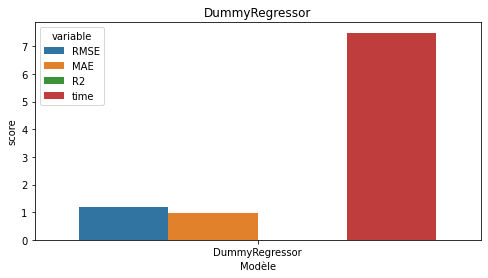

In [119]:
plt.figure(figsize=(8,4))
sns.barplot(x = Baseline['Modèle'],
            y = Baseline['score'], hue = Baseline['variable'])
plt.title('DummyRegressor')

Nous allons donc réaliser nos premières modélisations : 

#### <span style='color:blue '> 3.Prédiction de la consommation totale d'énergie (SiteEnergyUse) </span>


#### Séparation des jeux de données d'entraînement et de test

Nous allons d'abord Séparer des jeux de données d'entraînement et de test.  étant donné que les hyperparamètres et le modèle seront sélectionnées par une validation croisée, il n'est pas nécessaire de séparer jeux d'entraînement, de test et de validation.

In [120]:
X_train, X_test, y_train, y_test = train_test_split(X,y['SiteEnergyUse(kBtu)'], test_size=0.20, shuffle=True, random_state=42)


print("Entrainement: {} lignes,\nTest: {} lignes.\n".format(X_train.shape[0],
                                                            X_test.shape[0]))

Entrainement: 1247 lignes,
Test: 312 lignes.



#### <span style='color:orange '> 3.1.Modèle ElasticNet (SiteEnergyUse) </span>

In [121]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

parameters = {'tol' : [0.1,0.01,0.001,0.0001],  #critères d'arrêt
              # arrêt de rechercher un minimum (ou un maximum) une fois qu'une certaine tolérance est atteinte 
              "alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100], 
              "l1_ratio": np.arange(0.0, 1.0, 0.1)}  


elastic_grid = GridSearchCV(estimator = ElasticNet(random_state= 42), 
                            param_grid = parameters,
                            scoring='neg_root_mean_squared_error',
                            n_jobs=-1, #  le nombre de processus (tous les processeurs seront utilisés)
                            cv=5,
                            verbose=0
                            )

elastic_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=ElasticNet(random_state=42), n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                         'l1_ratio': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                         'tol': [0.1, 0.01, 0.001, 0.0001]},
             scoring='neg_root_mean_squared_error')

In [122]:
elastic_grid.best_params_

{'alpha': 0.0001, 'l1_ratio': 0.9, 'tol': 0.01}

l1_ratio est  de 0.30, signifiant que le poids du L2 est plus important que celui du L1 dans la régularisation

'Alpha’ : 0.1, donc, une régression Ridge est préféré

In [123]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

consommation_energy = pd.DataFrame({})

rmse = mean_squared_error(y_test, elastic_grid.predict(X_test), squared=False)
mae = mean_absolute_error(y_test, elastic_grid.predict(X_test))
r_squared = r2_score(y_test, elastic_grid.predict(X_test))
time = %timeit -o elastic_grid.best_estimator_.predict(X_test)

consommation_energy = consommation_energy.append(pd.DataFrame({'Modèle': ['LinearRegression'],
                                       'RMSE': rmse,
                                       'MAE': mae,
                                       'R²': r_squared,
                                       'Time_ms': time.best*1000,
                'Cv_score(RMSE)': -1 * elastic_grid.best_score_}),
                         ignore_index=True)

629 µs ± 14.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [124]:
consommation_energy

,Modèle,RMSE,MAE,R²,Time_ms,Cv_score(RMSE)
0,LinearRegression,0.856278,0.643673,0.47829,0.609883,0.837471


#### Coefficients de Elastic_Net

Text(0.5, 1.0, 'coefficients de Elastic_Net')

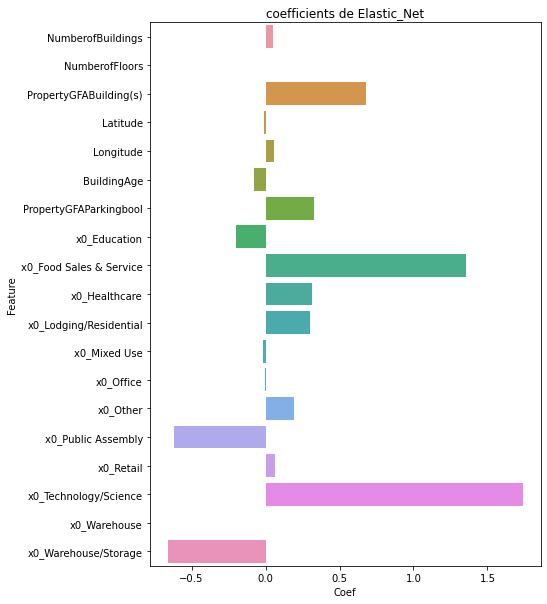

In [125]:
elastic_Coef=pd.DataFrame({'Feature': X_test.columns,
              'Coef': elastic_grid.best_estimator_.coef_})
plt.figure(figsize=(7,10))
sns.barplot(x = elastic_Coef['Coef'],
            y = elastic_Coef['Feature'])
plt.title('coefficients de Elastic_Net')

#### <span style='color:orange '> 3.2.Modèle Support Vector Machine (SVM) - (SiteEnergyUse) </span>

In [126]:
from sklearn.svm import SVR

parameters = {'gamma' : [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1], # distance pour calcul de la ligne de séparation plausible
              'epsilon' : [0.001, 0.01, 0.1, 1], #erreur tolérée par l'algorithme
              'C' : [0.001, 0.01, 0.1, 1, 10]} # parametre de régularisation(le paramètre de pénalité)

svm = GridSearchCV(estimator = SVR(), 
                      param_grid = parameters,
                      scoring='neg_root_mean_squared_error',
                      n_jobs=-1,
                      cv=5,
                      verbose=5
                     )

svm.fit(X_train, y_train)

Fitting 5 folds for each of 160 candidates, totalling 800 fits


GridSearchCV(cv=5, estimator=SVR(), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10],
                         'epsilon': [0.001, 0.01, 0.1, 1],
                         'gamma': [1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001,
                                   0.01, 0.1]},
             scoring='neg_root_mean_squared_error', verbose=5)

In [127]:
svm.best_params_

{'C': 10, 'epsilon': 0.1, 'gamma': 0.01}

In [128]:
rmse = mean_squared_error(y_test, svm.predict(X_test), squared=False)
mae = mean_absolute_error(y_test, svm.predict(X_test))
r_squared = r2_score(y_test, svm.predict(X_test))
time = %timeit -o  svm.best_estimator_.predict(X_test)

consommation_energy = consommation_energy.append(pd.DataFrame({'Modèle': ['SVR'],
                                       'RMSE': rmse,
                                       'MAE': mae,
                                       'R²': r_squared,
                                       'Time_ms': time.best*1000,
                    'Cv_score(RMSE)': -1 * svm.best_score_}),
                         ignore_index=True)

23.9 ms ± 709 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [129]:
consommation_energy

,Modèle,RMSE,MAE,R²,Time_ms,Cv_score(RMSE)
0,LinearRegression,0.856278,0.643673,0.478290,0.609883,0.837471
1,SVR,0.729695,0.553269,0.621137,23.110310,0.793167


#### <span style='color:orange '> 3.3. Modèle Random Forest Regressor (SiteEnergyUse) </span>

In [130]:
from sklearn.ensemble import RandomForestRegressor
parameters = {
    'n_estimators' : [100, 300, 500],  #nombre d'arbres de décision
  
    'min_samples_leaf' : [1, 2, 5], 
    #nombre de feuilles minimales dans un noeud
    'max_features': ['auto', 'sqrt'] 
    #nombre de features observées par arbre
}

R_Forest_grid = GridSearchCV(RandomForestRegressor(random_state=42),
                        param_grid=parameters,
                        scoring='neg_root_mean_squared_error',
                        n_jobs=-1,
                        verbose=5,
                        cv=5)

R_Forest_grid.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 5],
                         'n_estimators': [100, 300, 500]},
             scoring='neg_root_mean_squared_error', verbose=5)

In [131]:
R_Forest_grid.best_params_

{'max_features': 'auto', 'min_samples_leaf': 5, 'n_estimators': 300}

In [132]:
coefficients = abs(R_Forest_grid.best_estimator_.feature_importances_)
liste_coefs_rer = pd.concat((pd.DataFrame(X.columns, columns = ['Variable']), 
                      pd.DataFrame(coefficients, columns = ['Coefficient'])), axis = 1).sort_values(by='Coefficient', ascending = False)

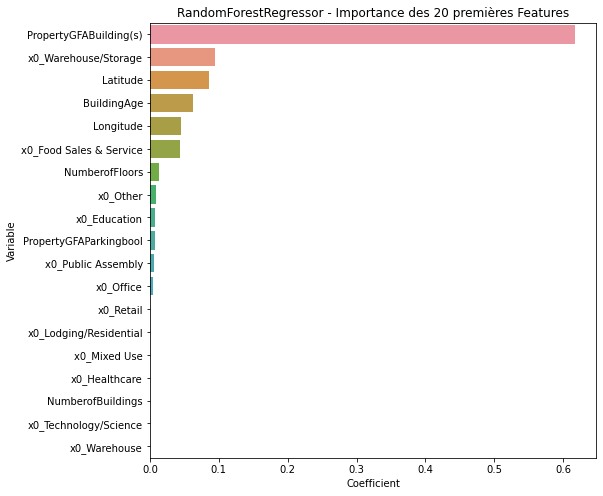

In [133]:
plt.figure(figsize=(8,8))
plt.title('RandomForestRegressor - Importance des 20 premières Features')
sns.barplot(y = liste_coefs_rer['Variable'].head(20),
            x = liste_coefs_rer['Coefficient'].head(20))
plt.show()

In [134]:
R_Forest_grid.best_score_

-0.8076902490295647

In [135]:
rmse = mean_squared_error(y_test, R_Forest_grid.predict(X_test), squared=False)
mae = mean_absolute_error(y_test, R_Forest_grid.predict(X_test))
r_squared = r2_score(y_test, R_Forest_grid.predict(X_test))
time = %timeit -o  R_Forest_grid.best_estimator_.predict(X_test)
consommation_energy = consommation_energy.append(pd.DataFrame({'Modèle': ['Random Forest Regressor'],
                                       'RMSE': rmse,
                                       'MAE': mae,
                                       'R²': r_squared,
                                       'Time_ms': time.best*1000,
                    'Cv_score(RMSE)': -1 * R_Forest_grid.best_score_}),
                         ignore_index=True)

20.6 ms ± 1.68 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [136]:
consommation_energy

,Modèle,RMSE,MAE,R²,Time_ms,Cv_score(RMSE)
0,LinearRegression,0.856278,0.643673,0.478290,0.609883,0.837471
1,SVR,0.729695,0.553269,0.621137,23.110310,0.793167
2,Random Forest Regressor,0.722297,0.522064,0.628780,18.997880,0.807690


#### <span style='color:orange '> 3.4.Modèle XGBoost (SiteEnergyUse) </span>

In [137]:
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [138]:

parameters = {
    'loss': ['ls', 'lad'],
    'n_estimators': [100, 200, 300],
    'min_samples_leaf': [1, 2, 5, 8, 12],
    'max_features': ['auto', 'sqrt'],
    'criterion': ['mse'],
}

xgb_grid = GridSearchCV(GradientBoostingRegressor(random_state= 42),
                        param_grid = parameters,
                        scoring='neg_root_mean_squared_error',
                        n_jobs = -1,
                        cv = 5,
                        verbose=5)

xgb_grid.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=42),
             n_jobs=-1,
             param_grid={'criterion': ['mse'], 'loss': ['ls', 'lad'],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 5, 8, 12],
                         'n_estimators': [100, 200, 300]},
             scoring='neg_root_mean_squared_error', verbose=5)

In [139]:
xgb_grid.best_params_

{'criterion': 'mse',
 'loss': 'lad',
 'max_features': 'sqrt',
 'min_samples_leaf': 8,
 'n_estimators': 300}

In [140]:
coefficients = abs(xgb_grid.best_estimator_.feature_importances_)
liste_coefs_rer = pd.concat((pd.DataFrame(X.columns, columns = ['Variable']), 
                      pd.DataFrame(coefficients, columns = ['Coefficient'])),
                       axis = 1).sort_values(by='Coefficient',
                                             ascending = False)

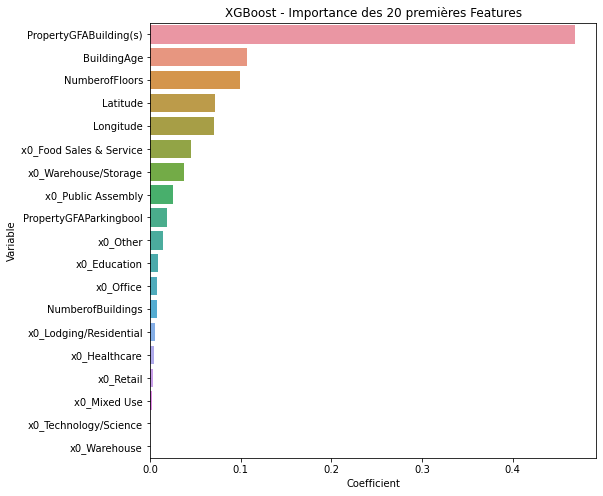

In [141]:
plt.figure(figsize=(8,8))
plt.title('XGBoost - Importance des 20 premières Features')
sns.barplot(y = liste_coefs_rer['Variable'].head(20),
            x = liste_coefs_rer['Coefficient'].head(20))
plt.show()

In [142]:
xgb_grid.best_score_

-0.7833072128105417

In [143]:
rmse = mean_squared_error(y_test, xgb_grid.predict(X_test), squared=False)
mae = mean_absolute_error(y_test, xgb_grid.predict(X_test))
r_squared = r2_score(y_test, xgb_grid.predict(X_test))
time = %timeit -o  xgb_grid.best_estimator_.predict(X_test)

consommation_energy = consommation_energy.append(pd.DataFrame({'Modèle': ['XGBoost'],
                                       'RMSE': rmse,
                                       'MAE': mae,
                                       'R²': r_squared,
                                       'Time_ms': time.best*1000,
                    'Cv_score(RMSE)': -1 * xgb_grid.best_score_}),
                         ignore_index=True)

1.62 ms ± 23 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [144]:
consommation_energy

,Modèle,RMSE,MAE,R²,Time_ms,Cv_score(RMSE)
0,LinearRegression,0.856278,0.643673,0.478290,0.609883,0.837471
1,SVR,0.729695,0.553269,0.621137,23.110310,0.793167
2,Random Forest Regressor,0.722297,0.522064,0.628780,18.997880,0.807690
3,XGBoost,0.718666,0.528532,0.632503,1.568572,0.783307


In [145]:
consommation_energy = consommation_energy.sort_values(by='R²', ascending=False)
consommation_energy

,Modèle,RMSE,MAE,R²,Time_ms,Cv_score(RMSE)
3,XGBoost,0.718666,0.528532,0.632503,1.568572,0.783307
2,Random Forest Regressor,0.722297,0.522064,0.628780,18.997880,0.807690
1,SVR,0.729695,0.553269,0.621137,23.110310,0.793167
0,LinearRegression,0.856278,0.643673,0.478290,0.609883,0.837471


 #### - Le meilleur modèle choisi: XGBoost 

Nous allons choisir XGBoost, comme le meilleur modèle de prédiction de la consommation d’Energie

In [146]:
comparaison = pd.melt(consommation_energy.reset_index(), id_vars = ['Modèle'], value_name = 'score', value_vars=["RMSE","MAE","R²","Time_ms"])

Text(0.5, 1.0, 'Comparaison des performances des modèles')

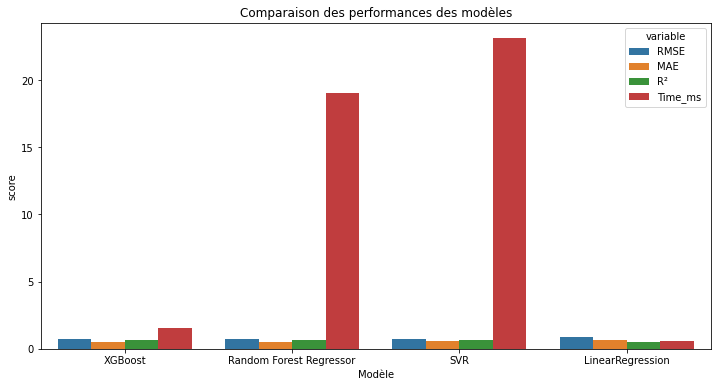

In [147]:
plt.figure(figsize=(12,6))
sns.barplot(x = comparaison['Modèle'],
            y = comparaison['score'], hue = comparaison['variable'])
plt.title('Comparaison des performances des modèles')

In [148]:
xgb_grid.best_params_

{'criterion': 'mse',
 'loss': 'lad',
 'max_features': 'sqrt',
 'min_samples_leaf': 8,
 'n_estimators': 300}

#### sauvegarde les paramètres de meilleur modèle 

In [149]:
best_param = xgb_grid.best_params_

for i in best_param:
  best_param[i] = list([best_param[i]])

joblib.dump(best_param, 'best_param_xgb_consomation.sav')

['best_param_xgb_consomation.sav']

#### <span style='color:blue'> 4.Prédiction de l’émission de CO2 (TotalGHGEmissions) </span>

In [150]:
X_train, X_test, y_train, y_test = train_test_split(X,y['TotalGHGEmissions'],
                                         test_size=0.20,
                                         shuffle=True, # mélanger les données avant de les diviser
                                         random_state=42,
                                         )
print("Entrainement: {} lignes,\nTest: {} lignes.\n".format(X_train.shape[0],
                                                            X_test.shape[0]))

Entrainement: 1247 lignes,
Test: 312 lignes.



#### <span style='color:orange'> 4.1. Modèle ElasticNet (TotalGHGEmissions) </span>

In [151]:
parameters = {'tol' : [0.1,0.01,0.001,0.0001],  #critères d'arrêt
              # arrêt de rechercher un minimum (ou un maximum) une fois qu'une certaine tolérance est atteinte, 
              "alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100], 
              "l1_ratio": np.arange(0.0, 1.0, 0.1)}  


elastic_grid = GridSearchCV(estimator = ElasticNet(random_state= 42), 
                            param_grid = parameters,
                            scoring='neg_root_mean_squared_error',
                            n_jobs=-1, #  le nombre de processus (tous les processeurs seront utilisés)
                            cv=5,
                            verbose=0
                            )

elastic_grid.fit(X_train, y_train)

C:\Users\sahel\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 94.52796740619681, tolerance: 19.65206459893834
  model = cd_fast.enet_coordinate_descent(


GridSearchCV(cv=5, estimator=ElasticNet(random_state=42), n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                         'l1_ratio': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                         'tol': [0.1, 0.01, 0.001, 0.0001]},
             scoring='neg_root_mean_squared_error')

In [152]:
elastic_grid.best_params_

{'alpha': 0.0001, 'l1_ratio': 0.2, 'tol': 0.01}

In [153]:
emissions_CO2 = pd.DataFrame({})

rmse = mean_squared_error(y_test, elastic_grid.predict(X_test), squared=False)
mae = mean_absolute_error(y_test, elastic_grid.predict(X_test))
r_squared = r2_score(y_test, elastic_grid.predict(X_test))
time = %timeit -o elastic_grid.best_estimator_.predict(X_test)

emissions_CO2 = emissions_CO2.append(pd.DataFrame({'Modèle': ['LinearRegression'],
                                       'RMSE': rmse,
                                       'MAE': mae,
                                       'R²': r_squared,
                                       'Time_ms': time.best*1000,
                'Cv_score(RMSE)': -1 * elastic_grid.best_score_}),
                         ignore_index=True)

607 µs ± 8.09 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [154]:
emissions_CO2

,Modèle,RMSE,MAE,R²,Time_ms,Cv_score(RMSE)
0,LinearRegression,1.123046,0.888573,0.262111,0.597614,0.978264


#### Coefficients de Elastic_Net

Text(0.5, 1.0, 'coefficients de Elastic_Net')

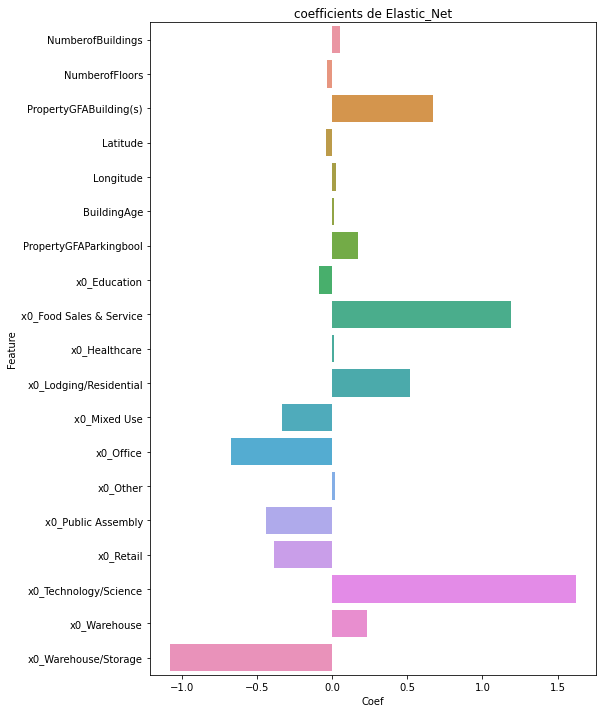

In [155]:
elastic_Coef=pd.DataFrame({'Feature': X_test.columns,
              'Coef': elastic_grid.best_estimator_.coef_})

plt.figure(figsize=(8,12))
sns.barplot(x = elastic_Coef['Coef'],
            y = elastic_Coef['Feature'])
plt.title('coefficients de Elastic_Net')

#### <span style='color:orange '> 4.2.Modèle Support Vector Machine (SVM)- (TotalGHGEmissions) </span>

In [156]:
parameters = {'gamma' : [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1], #kernel coefficient [ici kernel = Radial Basis Function]
              'epsilon' : [0.001, 0.01, 0.1, 1], #erreur tolérée par l'algorithme
              'C' : [0.001, 0.01, 0.1, 1, 10]} #parametre de régularisation

svm = GridSearchCV(estimator = SVR(),
                      param_grid = parameters,
                      scoring='neg_root_mean_squared_error',
                      n_jobs=-1,
                      cv=5,
                      verbose=5
                     )

svm.fit(X_train, y_train)

Fitting 5 folds for each of 160 candidates, totalling 800 fits


GridSearchCV(cv=5, estimator=SVR(), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10],
                         'epsilon': [0.001, 0.01, 0.1, 1],
                         'gamma': [1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001,
                                   0.01, 0.1]},
             scoring='neg_root_mean_squared_error', verbose=5)

In [157]:
svm.best_params_

{'C': 10, 'epsilon': 0.1, 'gamma': 0.01}

In [158]:
rmse = mean_squared_error(y_test, svm.predict(X_test), squared=False)
mae = mean_absolute_error(y_test, svm.predict(X_test))
r_squared = r2_score(y_test, svm.predict(X_test))
time = %timeit -o  svm.best_estimator_.predict(X_test)

emissions_CO2 = emissions_CO2.append(pd.DataFrame({'Modèle': ['SVR'],
                                       'RMSE': rmse,
                                       'MAE': mae,
                                       'R²': r_squared,
                                       'Time_ms': time.best*1000,
                    'Cv_score(RMSE)': -1 * svm.best_score_}),
                         ignore_index=True)

25.6 ms ± 618 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [159]:
emissions_CO2

,Modèle,RMSE,MAE,R²,Time_ms,Cv_score(RMSE)
0,LinearRegression,1.123046,0.888573,0.262111,0.597614,0.978264
1,SVR,1.032626,0.808189,0.376147,24.941490,0.952074


#### <span style='color:orange'> 4.3. Modèle Random Forest Regressor (TotalGHGEmissions)</span>

In [160]:
parameters = {
    'n_estimators' : [100, 300, 500],  #nombre d'arbres de décision
  
    'min_samples_leaf' : [1, 2, 5], 
    #nombre de feuilles minimales dans un noeud
    'max_features': ['auto', 'sqrt'] 
    #nombre de features observées par arbre
}

R_Forest_grid = GridSearchCV(RandomForestRegressor(random_state=42),
                        param_grid=parameters,
                        scoring='neg_root_mean_squared_error',
                        n_jobs=-1,
                        verbose=5,
                        cv=5)

R_Forest_grid.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 5],
                         'n_estimators': [100, 300, 500]},
             scoring='neg_root_mean_squared_error', verbose=5)

In [161]:
R_Forest_grid.best_params_

{'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 500}

In [162]:
coefficients = abs(R_Forest_grid.best_estimator_.feature_importances_)
liste_coefs_rer = pd.concat((pd.DataFrame(X.columns, columns = ['Variable']), 
                      pd.DataFrame(coefficients, columns = ['Coefficient'])), axis = 1).sort_values(by='Coefficient', ascending = False)

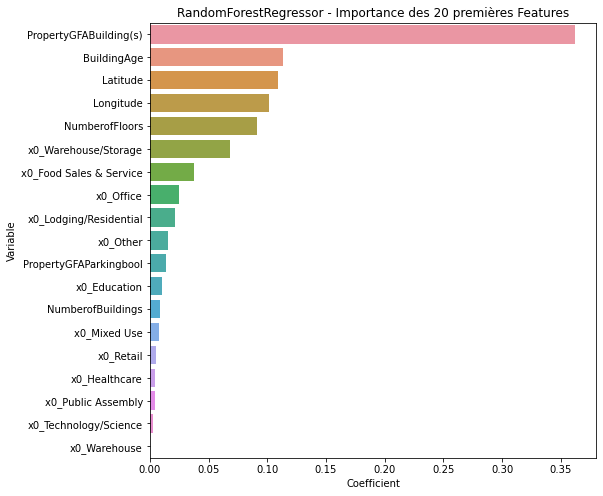

In [163]:
plt.figure(figsize=(8,8))
plt.title('RandomForestRegressor - Importance des 20 premières Features')
sns.barplot(y = liste_coefs_rer['Variable'].head(20),
            x = liste_coefs_rer['Coefficient'].head(20))
plt.show()

In [164]:
R_Forest_grid.best_score_

-0.9435099222918517

In [165]:
rmse = mean_squared_error(y_test, R_Forest_grid.predict(X_test), squared=False)
mae = mean_absolute_error(y_test, R_Forest_grid.predict(X_test))
r_squared = r2_score(y_test, R_Forest_grid.predict(X_test))
time = %timeit -o  R_Forest_grid.best_estimator_.predict(X_test)
emissions_CO2 = emissions_CO2.append(pd.DataFrame({'Modèle': ['Random Forest Regressor'],
                                       'RMSE': rmse,
                                       'MAE': mae,
                                       'R²': r_squared,
                                       'Time_ms': time.best*1000,
                    'Cv_score(RMSE)': -1 * R_Forest_grid.best_score_}),
                         ignore_index=True)

34.7 ms ± 868 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [166]:
emissions_CO2

,Modèle,RMSE,MAE,R²,Time_ms,Cv_score(RMSE)
0,LinearRegression,1.123046,0.888573,0.262111,0.597614,0.978264
1,SVR,1.032626,0.808189,0.376147,24.941490,0.952074
2,Random Forest Regressor,0.967798,0.757492,0.452019,33.908550,0.943510


#### <span style='color:orange'> 4.4. Modèle XGBoost (TotalGHGEmissions)</span>

In [167]:
parameters = {
    'loss': ['ls', 'lad'],
    'n_estimators': [100, 200, 300],
    'min_samples_leaf': [1, 2, 5, 8, 12],
    'max_features': ['auto', 'sqrt'],
    'criterion': ['mse'],
}

xgb_grid_co2 = GridSearchCV(GradientBoostingRegressor(random_state=0),
                        param_grid = parameters,
                        scoring='neg_root_mean_squared_error',
                        n_jobs = -1,
                        cv = 5,
                        verbose=5)

xgb_grid_co2.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=0),
             n_jobs=-1,
             param_grid={'criterion': ['mse'], 'loss': ['ls', 'lad'],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 5, 8, 12],
                         'n_estimators': [100, 200, 300]},
             scoring='neg_root_mean_squared_error', verbose=5)

In [168]:
xgb_grid_co2.best_params_

{'criterion': 'mse',
 'loss': 'lad',
 'max_features': 'auto',
 'min_samples_leaf': 8,
 'n_estimators': 200}

In [169]:
coefficients = abs(xgb_grid_co2.best_estimator_.feature_importances_)
liste_coefs_rer = pd.concat((pd.DataFrame(X.columns, columns = ['Variable']), 
                      pd.DataFrame(coefficients, columns = ['Coefficient'])),
                       axis = 1).sort_values(by='Coefficient',
                                             ascending = False)

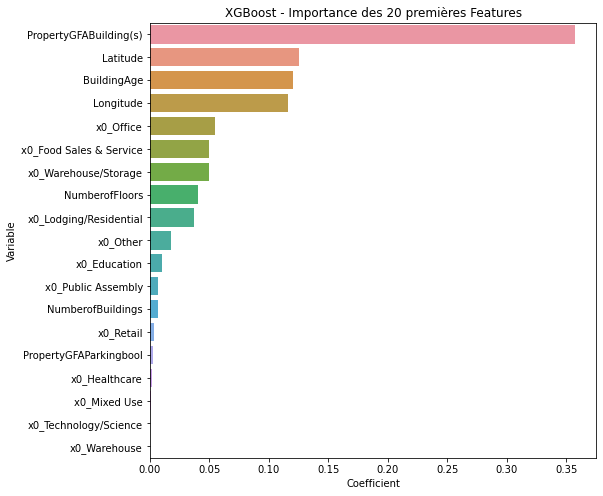

In [170]:
plt.figure(figsize=(8,8))
plt.title('XGBoost - Importance des 20 premières Features')
sns.barplot(y = liste_coefs_rer['Variable'].head(20),
            x = liste_coefs_rer['Coefficient'].head(20))
plt.show()

In [171]:
rmse = mean_squared_error(y_test, xgb_grid_co2.predict(X_test), squared=False)
mae = mean_absolute_error(y_test, xgb_grid_co2.predict(X_test))
r_squared = r2_score(y_test, xgb_grid_co2.predict(X_test))
time = %timeit -o  xgb_grid_co2.best_estimator_.predict(X_test)

emissions_CO2 = emissions_CO2.append(pd.DataFrame({'Modèle': ['XGBoost'],
                                       'RMSE': rmse,
                                       'MAE': mae,
                                       'R²': r_squared,
                                       'Time_ms': time.best*1000,
                    'Cv_score(RMSE)': -1 * xgb_grid_co2.best_score_}),
                         ignore_index=True)

1.34 ms ± 36.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [172]:
emissions_CO2

,Modèle,RMSE,MAE,R²,Time_ms,Cv_score(RMSE)
0,LinearRegression,1.123046,0.888573,0.262111,0.597614,0.978264
1,SVR,1.032626,0.808189,0.376147,24.941490,0.952074
2,Random Forest Regressor,0.967798,0.757492,0.452019,33.908550,0.943510
3,XGBoost,1.004343,0.765163,0.409853,1.289430,0.940137


In [173]:
emissions_CO2 = emissions_CO2.sort_values(by='R²', ascending=False)
emissions_CO2

,Modèle,RMSE,MAE,R²,Time_ms,Cv_score(RMSE)
2,Random Forest Regressor,0.967798,0.757492,0.452019,33.908550,0.943510
3,XGBoost,1.004343,0.765163,0.409853,1.289430,0.940137
1,SVR,1.032626,0.808189,0.376147,24.941490,0.952074
0,LinearRegression,1.123046,0.888573,0.262111,0.597614,0.978264


Les modèles XGBoost et Random Forest Regressor offrent des performances à peu près similaires pour la qualité des prédictions mais les temps de calculs sont meilleurs sur le modèle XGBoost.

In [174]:
comparaison = pd.melt(emissions_CO2.reset_index(), id_vars = ['Modèle'], value_name = 'score', value_vars=["RMSE","MAE","R²","Time_ms"])

Text(0.5, 1.0, 'Comparaison des performances des modèles')

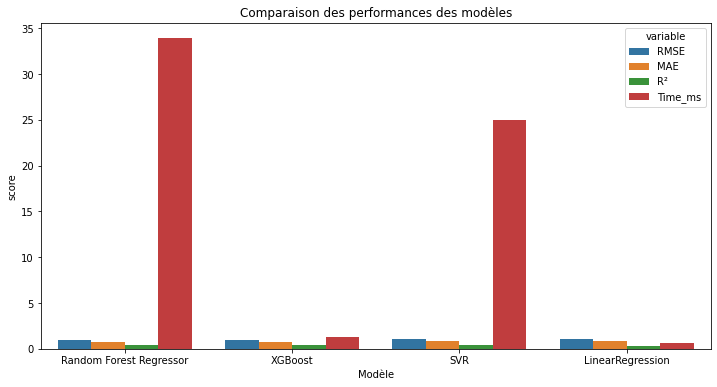

In [175]:
plt.figure(figsize=(12,6))
sns.barplot(x = comparaison['Modèle'],
            y = comparaison['score'], hue = comparaison['variable'])
plt.title('Comparaison des performances des modèles')

Avec la projection graphique ci-dessus, on constate que le modèle XGBoost offre le meilleur compromis score / temps. 

- Le modèle retenu pour la modélisation de la variable TotalGHGEmissions est donc le modèle XGBoost.

In [176]:
xgb_grid_co2.best_params_

{'criterion': 'mse',
 'loss': 'lad',
 'max_features': 'auto',
 'min_samples_leaf': 8,
 'n_estimators': 200}

#### sauvegarde les paramètres de meilleur modèle

In [177]:
best_param = xgb_grid_co2.best_params_

for i in best_param:
  best_param[i] = list([best_param[i]])

joblib.dump(best_param, 'best_param_xgb_CO2.sav')

['best_param_xgb_CO2.sav']

In [178]:
#load saved model
# best_param = joblib.load(best_param_xgb_CO2.sav)

#### <span style='color:blue'> 5.Influence de la variable 'ENERGY STAR Score </span>

Nous cherchons en particulier à évaluer l'intérêt de l’'ENERGY STAR Score' (www.energystar.gov) pour la prédiction d’émissions, qui est fastidieux à calculer avec l’approche utilisée actuellement par l'équipe.

Nous allons donc évaluer si ce score à un impact significatif sur les performances de notre modélisation.

In [179]:
X_enS = X.copy()

In [180]:
#Ajout de 'ENERGYSTARScore' aux variables X
X_enS['energy_star_score'] = energy_star_score

In [181]:
y_enS = data_clean[['SiteEnergyUse(kBtu)','TotalGHGEmissions']]

In [182]:
X_enS.head(1)

,NumberofBuildings,NumberofFloors,PropertyGFABuilding(s),Latitude,Longitude,BuildingAge,PropertyGFAParkingbool,x0_Education,x0_Food Sales & Service,x0_Healthcare,x0_Lodging/Residential,x0_Mixed Use,x0_Office,x0_Other,x0_Public Assembly,x0_Retail,x0_Technology/Science,x0_Warehouse,x0_Warehouse/Storage,energy_star_score
0,-0.065008,0.654731,0.000832,-0.183604,-0.165021,1.67041,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,45.0


#### <span style='color:darkviolet'>Standardisation de ENERGYSTARScore </span>

In [183]:
col_names = ['energy_star_score']
features = X_enS[col_names]

In [184]:
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)

In [185]:
X_enS[col_names] = features

In [186]:
X_enS_train, X_enS_test, y_enS_train, y_enS_test = train_test_split(X_enS,y_enS['TotalGHGEmissions'], test_size=0.20,random_state=42)


print("Entrainement: {} lignes,\nTest: {} lignes.\n".format(X_enS_train.shape[0],
                                                            X_enS_test.shape[0]))

Entrainement: 1247 lignes,
Test: 312 lignes.



On utilise ici le meilleur modèle calculé sur la variable TotalGHGEmissions en incluant l'ENERGY STAR Score :

In [187]:
Parameters = {
    'loss': ['ls'],
    'n_estimators': [300],
    'min_samples_leaf': [1],
    'max_features': ['auto'],
    'criterion': ['mse'],
}

xgb_grid_star = GridSearchCV(GradientBoostingRegressor(random_state=42),
                        param_grid = parameters,
                        scoring='neg_root_mean_squared_error',
                        n_jobs = -1,
                        cv = 5,
                        verbose=5)

xgb_grid_star.fit(X_enS_train, y_enS_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=42),
             n_jobs=-1,
             param_grid={'criterion': ['mse'], 'loss': ['ls', 'lad'],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 5, 8, 12],
                         'n_estimators': [100, 200, 300]},
             scoring='neg_root_mean_squared_error', verbose=5)

In [188]:
coefficients = abs(xgb_grid_star.best_estimator_.feature_importances_)
liste_coefs_rer = pd.concat((pd.DataFrame(X_enS.columns, columns = ['Variable']), 
                      pd.DataFrame(coefficients, columns = ['Coefficient'])),
                       axis = 1).sort_values(by='Coefficient',
                                             ascending = False)

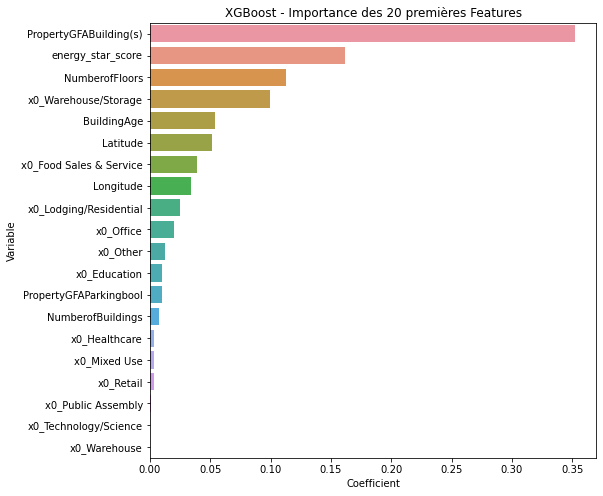

In [189]:
plt.figure(figsize=(8,8))
plt.title('XGBoost - Importance des 20 premières Features')
sns.barplot(y = liste_coefs_rer['Variable'].head(20),
            x = liste_coefs_rer['Coefficient'].head(20))
plt.show()

In [190]:
Energy_Star = pd.DataFrame({})

rmse = mean_squared_error(y_enS_test, xgb_grid_star.predict(X_enS_test), squared=False)
mae = mean_absolute_error(y_enS_test, xgb_grid_star.predict(X_enS_test))
r_squared = r2_score(y_enS_test, xgb_grid_star.predict(X_enS_test))
time = %timeit -o  xgb_grid_star.best_estimator_.predict(X_enS_test)

emissions_CO2 = emissions_CO2.append(pd.DataFrame({'Modèle': ['XGBoost_Energy_Star'],
                                       'RMSE': rmse,
                                       'MAE': mae,
                                       'R²': r_squared,
                                       'Time_ms': time.best*1000,
                    'Cv_score(RMSE)': -1 * xgb_grid_star.best_score_}),
                         ignore_index=True)

1.38 ms ± 15.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [191]:
emissions_CO2

,Modèle,RMSE,MAE,R²,Time_ms,Cv_score(RMSE)
0,Random Forest Regressor,0.967798,0.757492,0.452019,33.908550,0.943510
1,XGBoost,1.004343,0.765163,0.409853,1.289430,0.940137
2,SVR,1.032626,0.808189,0.376147,24.941490,0.952074
3,LinearRegression,1.123046,0.888573,0.262111,0.597614,0.978264
4,XGBoost_Energy_Star,0.923717,0.731056,0.500800,1.363589,0.862378


In [192]:
emissions_CO2 = emissions_CO2.sort_values(by='R²', ascending=False)
emissions_CO2

,Modèle,RMSE,MAE,R²,Time_ms,Cv_score(RMSE)
4,XGBoost_Energy_Star,0.923717,0.731056,0.500800,1.363589,0.862378
0,Random Forest Regressor,0.967798,0.757492,0.452019,33.908550,0.943510
1,XGBoost,1.004343,0.765163,0.409853,1.289430,0.940137
2,SVR,1.032626,0.808189,0.376147,24.941490,0.952074
3,LinearRegression,1.123046,0.888573,0.262111,0.597614,0.978264


En ajoutant Energy Star Score à notre modèle, la performance du modèle s'améliore très légèrement.